# Sharp regression discontinuity with `pymc` models

In [1]:
import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

In [3]:
df = cp.load_data("rd")

## Linear, main-effects, and interaction model

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


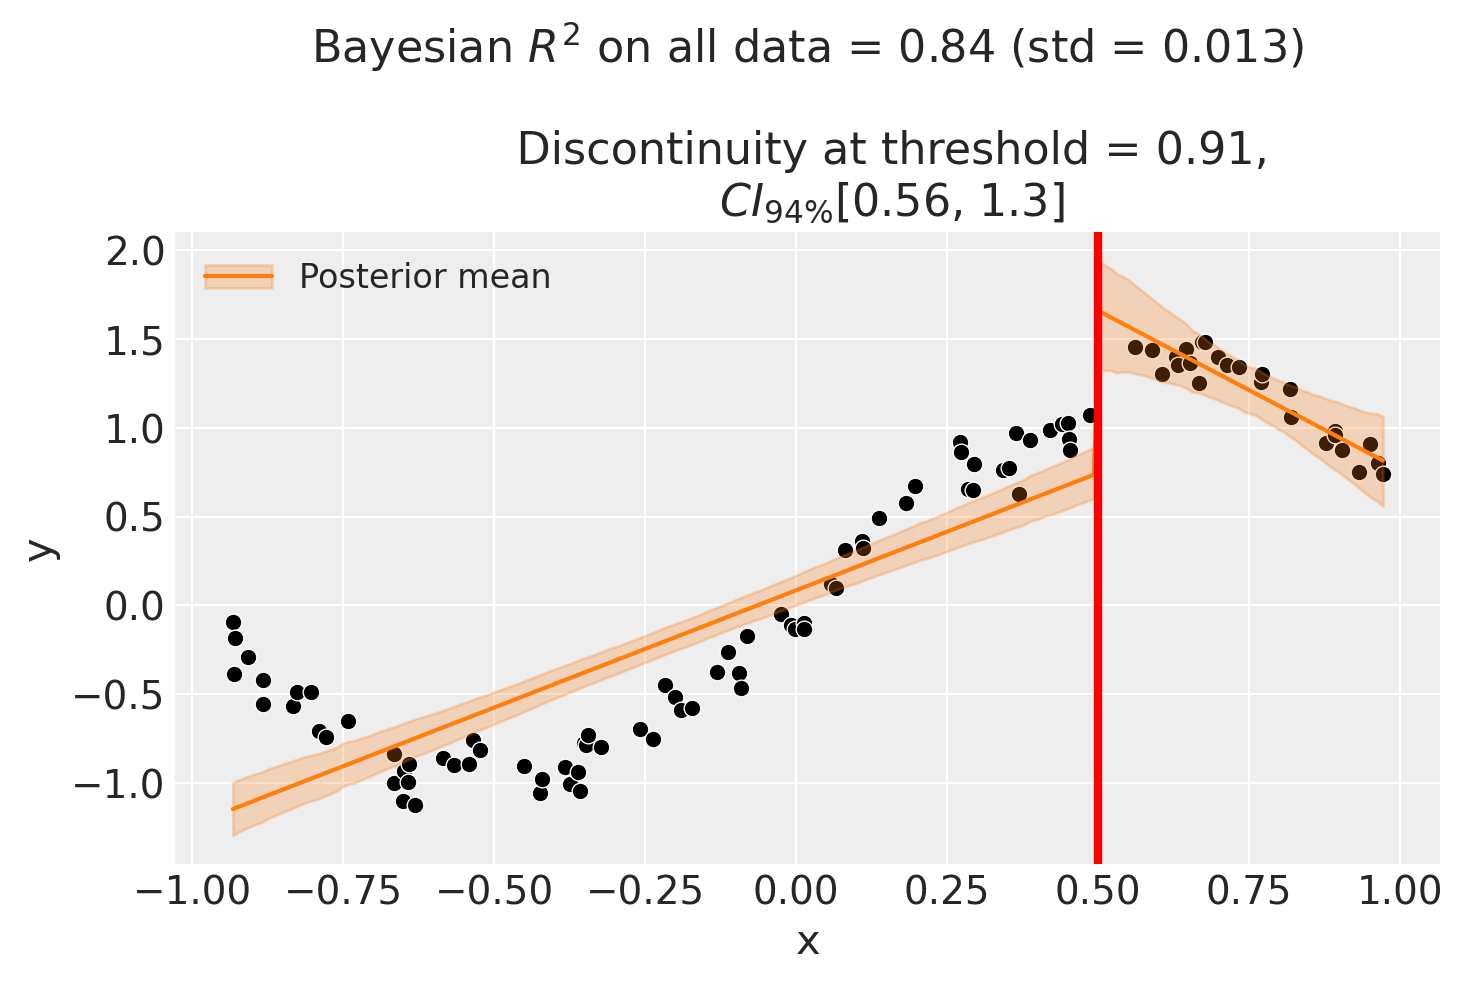

In [4]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
)

fig, ax = result.plot()

Though we can see that this does not give a good fit of the data almost certainly overestimates the discontinuity at threshold.

## Using a bandwidth

One way how we could deal with this is to use the `bandwidth` kwarg. This will only fit the model to data within a certain bandwidth of the threshold. If $x$ is the running variable, then the model will only be fitted to data where $threshold - bandwidth \le x \le threshold + bandwidth$.

In [5]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
    bandwidth=0.3,
)

fig, ax = result.plot()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


We could even go crazy and just fit intercepts for the data close to the threshold. But clearly this will involve more estimation error as we are using less data.

In [6]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
    bandwidth=0.2,
)

fig, ax = result.plot()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


## Using basis splines

Though it could arguably be better to fit with a more complex model, fit example a spline. This allows us to use all of the data, and (depending on the situation) maybe give a better fit.

In [7]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + bs(x, df=6) + treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
)

fig, ax = result.plot()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


As with all of the models in this notebook, we can ask for a summary of the model coefficients.

In [8]:
result.summary()

Difference in Differences experiment
Formula: y ~ 1 + bs(x, df=6) + treated
Running variable: x
Threshold on running variable: 0.5

Results:
Discontinuity at threshold = 0.41$CI_{94\%}$[0.23, 0.59]


Model coefficients:
    Intercept        -0.23, 94% HDI [-0.32, -0.14]
    treated[T.True]  0.41, 94% HDI [0.23, 0.59]
    bs(x, df=6)[0]   -0.59, 94% HDI [-0.79, -0.41]
    bs(x, df=6)[1]   -1.1, 94% HDI [-1.2, -0.93]
    bs(x, df=6)[2]   0.28, 94% HDI [0.11, 0.43]
    bs(x, df=6)[3]   1.7, 94% HDI [1.5, 1.8]
    bs(x, df=6)[4]   1, 94% HDI [0.67, 1.4]
    bs(x, df=6)[5]   0.57, 94% HDI [0.37, 0.76]
    y_hat_sigma      0.1, 94% HDI [0.089, 0.12]


## Effect Summary Reporting

For decision-making, you often need a concise summary of the causal effect. The `effect_summary()` method provides a decision-ready report with key statistics. Note that for Regression Discontinuity, the effect is a single scalar (the discontinuity at the threshold), similar to Difference-in-Differences.


In [9]:
# Generate effect summary
stats = result.effect_summary()
stats.table

,mean,median,hdi_lower,hdi_upper,p_gt_0
discontinuity,0.408901,0.406947,0.229298,0.595095,1.0


In [10]:
print(stats.text)

The discontinuity at threshold was 0.41 (95% HDI [0.23, 0.60]), with a posterior probability of an increase of 1.000.


You can customize the summary with different directions and ROPE thresholds:

- **Direction**: Test for increase, decrease, or two-sided effect
- **Alpha**: Set the HDI confidence level (default 95%)
- **ROPE**: Specify a minimal effect size threshold


In [11]:
# Example: Two-sided test with ROPE
stats = result.effect_summary(
    direction="two-sided",
    alpha=0.05,
    min_effect=0.2,  # Region of Practical Equivalence
)
stats.table

,mean,median,hdi_lower,hdi_upper,p_two_sided,prob_of_effect,p_rope
discontinuity,0.408901,0.406947,0.229298,0.595095,0.0,1.0,0.98875


In [12]:
print("\n" + stats.text)


The discontinuity at threshold was 0.41 (95% HDI [0.23, 0.60]), with a posterior probability of an effect of 1.000.
